In [41]:
!pip install tensorflow pydot

Defaulting to user installation because normal site-packages is not writeable


In [42]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics
import tensorflow as tf

warnings.filterwarnings("ignore")

In [43]:
path = r"465 dataset/Axial"

data = tf.keras.utils.image_dataset_from_directory(directory = path, image_size = (128, 128), batch_size = 10000)

Found 5154 files belonging to 3 classes.


In [44]:
class_names = data.class_names
print(class_names)

['AD', 'CI', 'CN']


In [45]:
label_map = {m : n for m, n in zip(np.arange(len(class_names)), class_names)}
print(label_map)

{0: 'AD', 1: 'CI', 2: 'CN'}


In [46]:
for images, labels in data:
    X = images.numpy().astype("uint8")
    y = labels.numpy().astype("uint8")

print(X.shape, y.shape)

(5154, 128, 128, 3) (5154,)


In [47]:
X_gray = np.zeros(shape = (*X.shape[:-1], 1))

for idx, img in enumerate(X):
    X_gray[idx] = tf.image.rgb_to_grayscale(img)

X = X_gray.copy()
print(X_gray.shape)

(5154, 128, 128, 1)


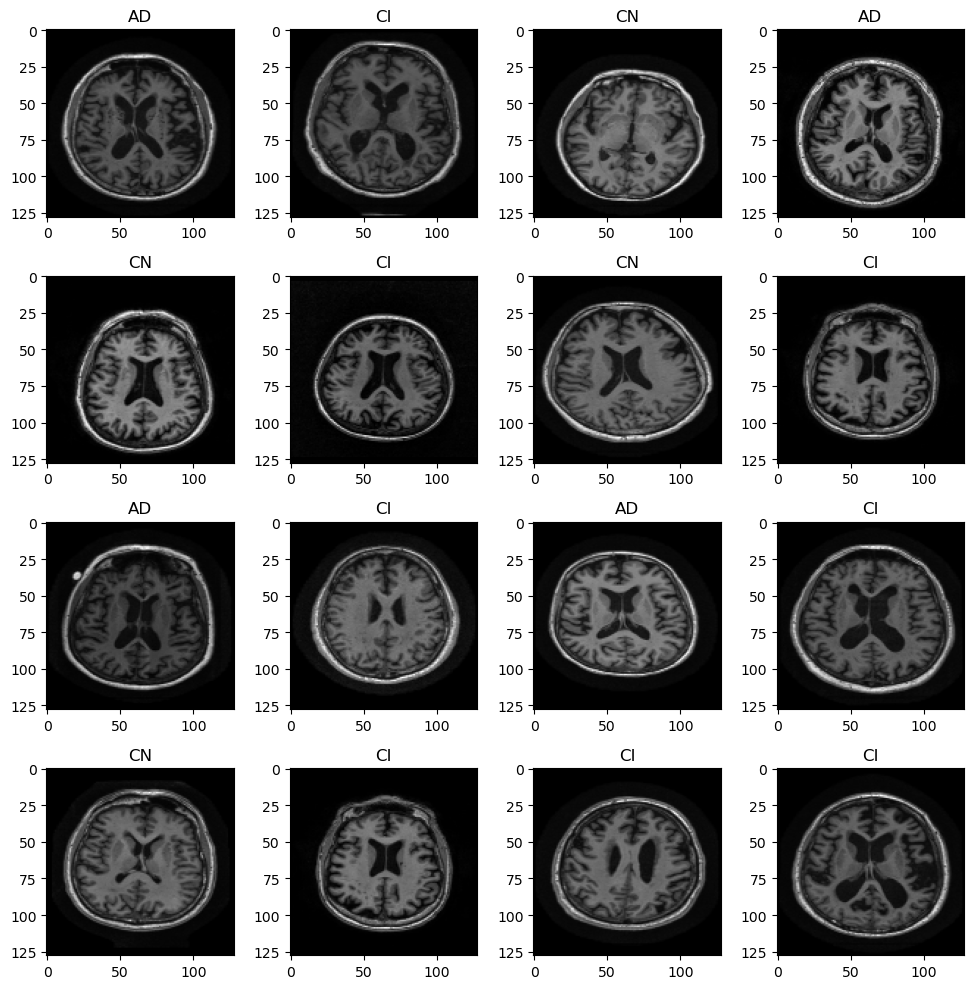

In [48]:
plt.figure(figsize = (10, 10))

for i in range(16):
    img = X[i]
    plt.subplot(4, 4, i + 1)
    plt.title(label_map[y[i]])
    plt.gray()
    plt.imshow(img)
    plt.tight_layout()
plt.show()

AD


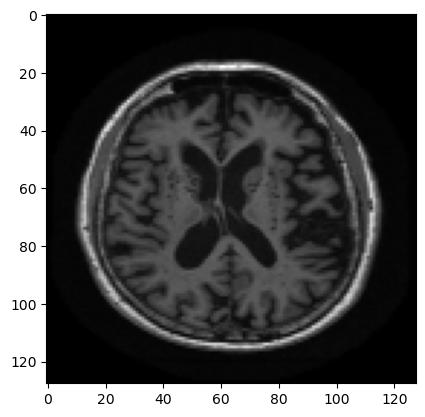

CI


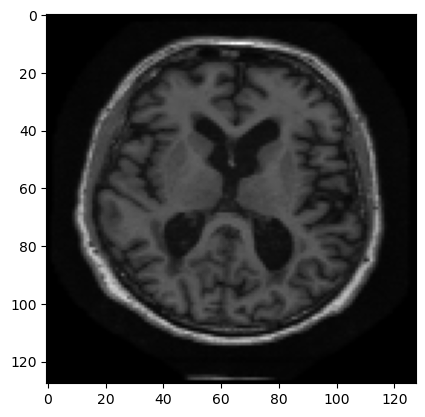

CN


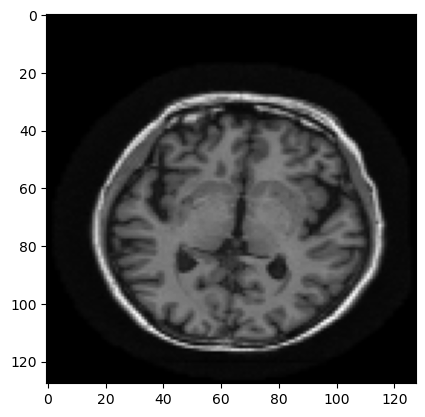

In [49]:
visited = set()

for img, label in zip(X_gray, y):
    if len(visited) == 3:
        break
    if label in visited:
        continue
    visited.add(label)
    print(label_map[label])
    plt.gray()
    plt.imshow(img)
    plt.show()

In [50]:
label_counts = pd.Series(y).value_counts()
print(label_counts)

1    2590
2    1440
0    1124
Name: count, dtype: int64


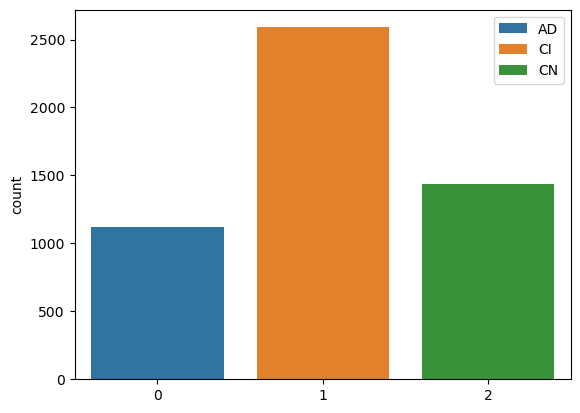

In [51]:
sns.countplot(x = y, label = label_map.values())
plt.legend()
plt.show()

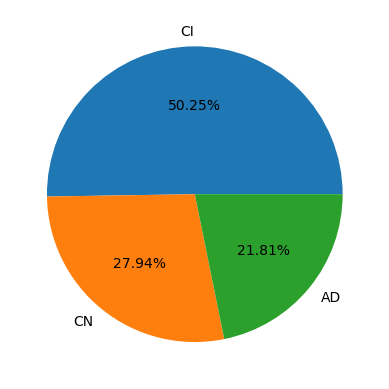

In [52]:
plt.pie(label_counts, autopct = "%.2f%%", labels = list(map(lambda key : label_map[key], label_counts.keys())))
plt.show()

In [53]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Create a data generator with augmentation
# data_gen = ImageDataGenerator(
#     rotation_range=20,  # Rotate images up to 20 degrees
#     width_shift_range=0.1,  # Shift images horizontally by 10%
#     height_shift_range=0.1,  # Shift images vertically by 10%
#     shear_range=0.1,  # Shearing
#     zoom_range=0.1,  # Zoom in/out by 10%
#     horizontal_flip=True,  # Flip images horizontally
#     fill_mode='nearest'  # Filling strategy for augmented pixels
# )

# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip(mode = "horizontal_and_vertical"),
# ])

In [54]:
# X_new, y_new = [], []
# max_total = 3000
# X_0, X_1, X_2 = X[y == 0], X[y == 1], X[y == 2]

# for label, X_set in zip(label_map.keys(), [X_0, X_1, X_2]):
#     count = 0
#     for img in X_set:
#         if count > max_total - label_counts[label]:
#             break
#         for i in range(2):
#             augmented_img = data_augmentation(img)
#             X_new.append(augmented_img)
#             y_new.append(label)
#             count += 1

# X_new, y_new = np.array(X_new), np.array(y_new)
# print(X_new.shape, y_new.shape)

import tensorflow as tf
import numpy as np

# Define the improved data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),              # Horizontal flip
    tf.keras.layers.RandomRotation(0.05),                  # Small rotation (5%)
    tf.keras.layers.RandomTranslation(0.05, 0.05),         # Small shift (5%)
    tf.keras.layers.RandomContrast(0.15),                  # Slight contrast variation (15%)
    tf.keras.layers.Lambda(lambda x: x + tf.random.normal(tf.shape(x), mean=0.0, stddev=0.01)),  # Add Gaussian noise
])

# Initialize lists for new augmented data
X_new, y_new = [], []
max_total = 3000
X_0, X_1, X_2 = X[y == 0], X[y == 1], X[y == 2]

# Generate augmented data per class to balance
for label, X_set in zip(label_map.keys(), [X_0, X_1, X_2]):
    count = 0
    for img in X_set:
        if count >= max_total - label_counts[label]:
            break
        for _ in range(3):  # Generate three augmentations per image
            augmented_img = data_augmentation(img[None, ...])  # Add batch dimension
            X_new.append(tf.squeeze(augmented_img).numpy())    # Squeeze and convert to numpy
            y_new.append(label)
            count += 1

# Convert lists to arrays and ensure dimensions match
X_new, y_new = np.array(X_new), np.array(y_new)

# Ensure `X` and `X_new` have the same number of dimensions
if X.ndim == 3:  # If X is [num_samples, height, width]
    X = np.expand_dims(X, axis=-1)  # Convert to [num_samples, height, width, channels]
if X_new.ndim == 3:
    X_new = np.expand_dims(X_new, axis=-1)

# Concatenate original and augmented datasets
X = np.concatenate([X, X_new], axis=0)
y = np.concatenate([y, y_new], axis=0)

print("Final augmented dataset shape:", X.shape, y.shape)


Final augmented dataset shape: (9003, 128, 128, 1) (9003,)


In [55]:
# X = np.concatenate([X, X_new])
# y = np.concatenate([y, y_new])

# print(X.shape, y.shape)

In [56]:
print(pd.Series(y).value_counts())

0    3002
1    3001
2    3000
Name: count, dtype: int64


In [57]:
# Min-Max Normalization

X = X / 255.0

print(X.min(), X.max())

-0.000215838352839152 1.0000784481272977


In [58]:
# Splitting the data into training, testing and validation sets

X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(X, y, test_size = 0.15,
                                                                            random_state = 3, stratify = y)

X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_val, y_train_val, test_size = 0.15,
                                                                  random_state = 3, stratify = y_train_val)

print(X_train.shape, X_val.shape, X_test.shape)

print(f"Total instances: {X.shape[0]}\nTrain instances: {X_train.shape[0]}   \
        \nValidation instances: {X_val.shape[0]}\nTest instances: {X_test.shape[0]}")

(6504, 128, 128, 1) (1148, 128, 128, 1) (1351, 128, 128, 1)
Total instances: 9003
Train instances: 6504           
Validation instances: 1148
Test instances: 1351


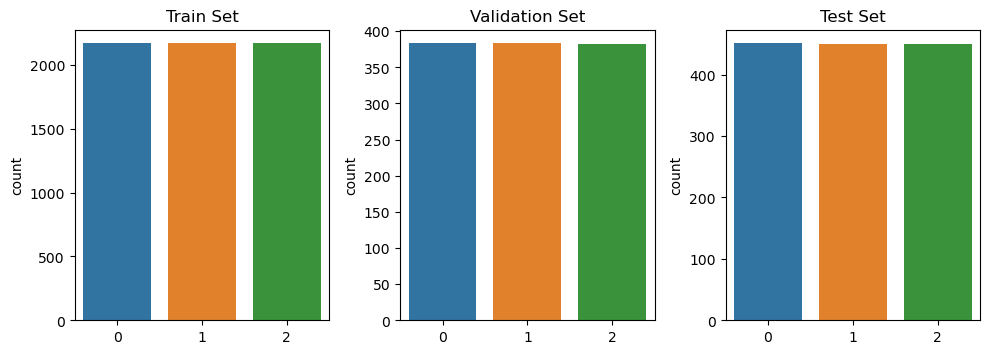

In [59]:
# Checking whether the classes are distributed uniformely among train, test and validation sets

plt.figure(figsize = (10, 10))

for i, labels, label_name in zip(range(3), [y_train, y_val, y_test], ["Train Set", "Validation Set", "Test Set"]):
    plt.subplot(3, 3, i + 1)
    plt.title(label_name)
    sns.countplot(x = labels)
    plt.tight_layout()
plt.show()

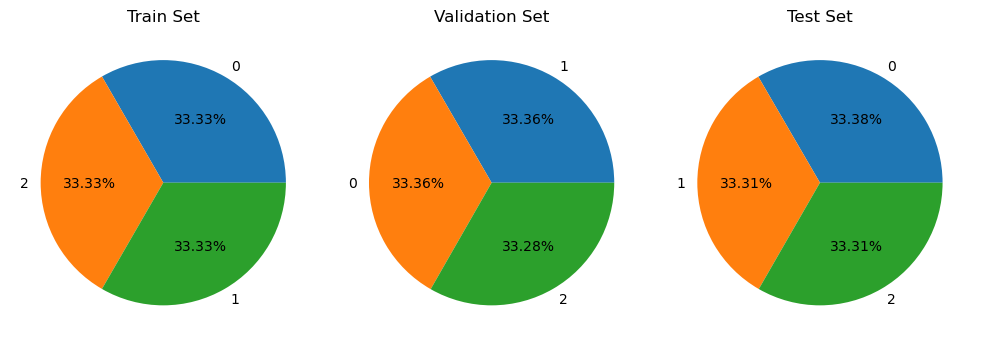

In [60]:
plt.figure(figsize = (10, 10))

for i, labels, label_name in zip(range(3), [y_train, y_val, y_test], ["Train Set", "Validation Set", "Test Set"]):
    plt.subplot(3, 3, i + 1)
    plt.title(label_name)
    label_counts = pd.Series(labels).value_counts()
    plt.pie(label_counts, autopct = "%.2f%%", labels = label_counts.keys())
    plt.tight_layout()
plt.show()

In [61]:
# # Model building

# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(filters = 200, kernel_size = (3, 3), input_shape = X_train.shape[1:], activation = "relu"),
#     tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
#     tf.keras.layers.Conv2D(filters = 100, kernel_size = (3, 3), input_shape = X_train.shape[1:], activation = "relu"),
#     tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(units = 100, activation = "relu"),
#     tf.keras.layers.Dense(units = 50, activation = "relu"),
#     tf.keras.layers.Dense(units = 3, activation = "softmax")
# ])

from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

# Example of adding Dropout after dense layers
model = tf.keras.models.Sequential([
    # Example CNN layers
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1:])),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),

    # Adding L2 regularization to the Dense layer
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),

    # Add dropout layer here with a 30% dropout rate
    tf.keras.layers.Dropout(0.3),  # Adjust the dropout rate (0.3) as needed

    tf.keras.layers.Dense(128, activation='relu'),

    # Another dropout layer
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(units = 3, activation='softmax')
])


In [62]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,320,963 (12.67 MB)

 Trainable params: 3,320,963 (12.67 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
for idx, layer in enumerate(model.layers):
    print(f"Layer {idx}:", layer.name, layer.output.shape, layer.count_params())

Layer 0: conv2d_3 (None, 126, 126, 32) 320
Layer 1: max_pooling2d_3 (None, 63, 63, 32) 0
Layer 2: conv2d_4 (None, 61, 61, 64) 18496
Layer 3: max_pooling2d_4 (None, 30, 30, 64) 0
Layer 4: conv2d_5 (None, 28, 28, 128) 73856
Layer 5: max_pooling2d_5 (None, 14, 14, 128) 0
Layer 6: flatten_1 (None, 25088) 0
Layer 7: dense_3 (None, 128) 3211392
Layer 8: dropout_2 (None, 128) 0
Layer 9: dense_4 (None, 128) 16512
Layer 10: dropout_3 (None, 128) 0
Layer 11: dense_5 (None, 3) 387


In [64]:
model_arch = tf.keras.utils.plot_model(model, show_shapes = True)
model_arch

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [65]:
model.compile(optimizer = "adam", loss = "SparseCategoricalCrossentropy", metrics = ["accuracy"])

In [66]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Create a data generator with augmentation
# data_gen = ImageDataGenerator(
#     rotation_range=20,  # Rotate images up to 20 degrees
#     width_shift_range=0.1,  # Shift images horizontally by 10%
#     height_shift_range=0.1,  # Shift images vertically by 10%
#     shear_range=0.1,  # Shearing
#     zoom_range=0.1,  # Zoom in/out by 10%
#     horizontal_flip=True,  # Flip images horizontally
#     fill_mode='nearest'  # Filling strategy for augmented pixels
# )

In [67]:
cb1 = tf.keras.callbacks.ModelCheckpoint("clf_model.keras", save_best_only=True)
cb2 = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
cb3 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.01)

history = model.fit(X_train, y_train, epochs=100, callbacks=[cb1, cb2, cb3], validation_data=(X_val, y_val))

# cb1 = tf.keras.callbacks.ModelCheckpoint("clf_model.keras", save_best_only=True)
# cb2 = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
# cb3 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

# # Add the new callback to the list
# history = model.fit(
#     data_gen.flow(X_train, y_train, batch_size=32),
#     epochs=100,
#     validation_data=(X_val, y_val),
#     callbacks=[cb1, cb2, cb3]
# )

Epoch 1/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 30s 136ms/step - accuracy: 0.3578 - loss: 1.1606 - val_accuracy: 0.4782 - val_loss: 1.0293 - learning_rate: 0.0010
Epoch 2/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - accuracy: 0.5235 - loss: 0.9866 - val_accuracy: 0.6585 - val_loss: 0.7740 - learning_rate: 0.0010
Epoch 3/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - accuracy: 0.6779 - loss: 0.7761 - val_accuracy: 0.7875 - val_loss: 0.5982 - learning_rate: 0.0010
Epoch 4/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - accuracy: 0.7706 - loss: 0.6138 - val_accuracy: 0.8179 - val_loss: 0.5174 - learning_rate: 0.0010
Epoch 5/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - accuracy: 0.8405 - loss: 0.4822 - val_accuracy: 0.8728 - val_loss: 0.4351 - learning_rate: 0.0010
Epoch 6/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 28s 136ms/step - accuracy: 0.8741 - loss: 0.4383 - val_accuracy: 0.9042 - val_loss: 0.3720 - learning_rate: 0.0010
Epoch 7/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 27s 132ms/step - accura

In [68]:
result_df = pd.DataFrame(history.history)
result_df.head()

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.397755,1.106924,0.478223,1.029299,0.001
1,0.560578,0.936304,0.658537,0.773981,0.001
2,0.702798,0.738006,0.787456,0.598195,0.001
3,0.787977,0.585691,0.817944,0.517368,0.001
4,0.840560,0.489637,0.872822,0.435065,0.001


In [69]:
result_df.describe()

,accuracy,loss,val_accuracy,val_loss,learning_rate
count,15.000000,15.000000,15.000000,15.000000,15.000
mean,0.837587,0.467914,0.850290,0.473596,0.001
std,0.164064,0.263274,0.125870,0.192581,0.000
min,0.397755,0.262242,0.478223,0.342519,0.001
25%,0.814268,0.289975,0.845383,0.374163,0.001
50%,0.909748,0.347414,0.904181,0.387581,0.001
75%,0.939653,0.537664,0.917247,0.476217,0.001
max,0.950953,1.106924,0.925958,1.029299,0.001


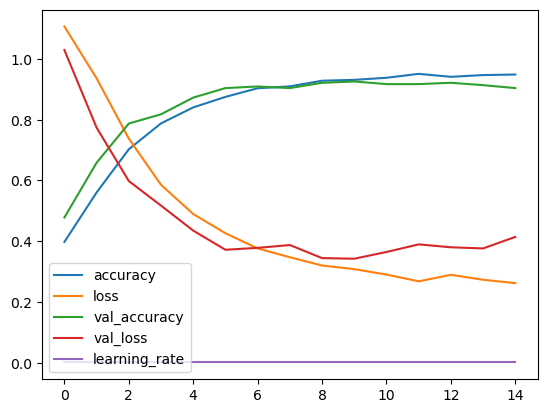

In [70]:
result_df.plot()
plt.show()


In [71]:
loss, acc = model.evaluate(X_train, y_train)

204/204 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9788 - loss: 0.2029


In [72]:
# Confusion Matrix

y_train_pred = model.predict(X_train)
y_train_pred_labels = np.array([np.argmax(y_) for y_ in y_train_pred])

cm = tf.math.confusion_matrix(labels = y_train, predictions = y_train_pred_labels)
print(cm)

204/204 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step
tf.Tensor(
[[2130   17   21]
 [  51 2104   13]
 [  19    9 2140]], shape=(3, 3), dtype=int32)


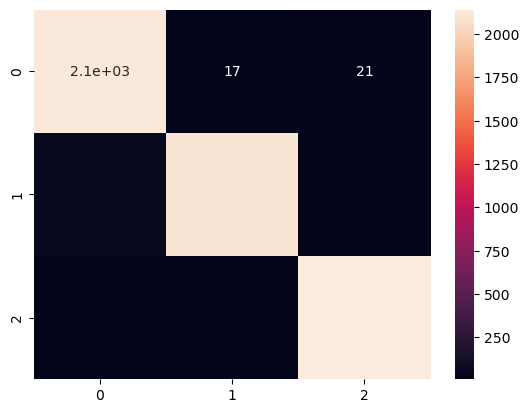

In [73]:
sns.heatmap(cm, annot = True)
plt.show()

In [74]:
tp_0, tn_0 = cm[0][0], cm[1][1] + cm[1][2] + cm[2][1] + cm[2][2]
fp_0, fn_0 = cm[1][0] + cm[2][0], cm[0][1] + cm[0][2]

tp_1, tn_1 = cm[1][1], cm[0][0] + cm[0][2] + cm[2][0] + cm[2][2]
fp_1, fn_1 = cm[0][1] + cm[2][1], cm[1][0] + cm[1][2]

tp_2, tn_2 = cm[2][2], cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]
fp_2, fn_2 = cm[0][2] + cm[1][2], cm[2][0] + cm[2][1]

def describeCM(tp, tn, fp, fn, i):
    print(f"\n\nClass {label_map[i]} : \n")
    print(f"True Positives : {tp}\nTrue Negatives : {tn}\nFalse Positives : {fp}\nFalse Negatives : {fn}")
    precision, recall = tp / (tp + fp), tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f"\nPrecision : {precision}\nRecall (Sensitivity) : {recall}\nF1-Score : {f1}")

describeCM(tp_0, tn_0, fp_0, fn_0, 0)
describeCM(tp_1, tn_1, fp_1, fn_1, 1)
describeCM(tp_2, tn_2, fp_2, fn_2, 2)



Class AD : 

True Positives : 2130
True Negatives : 4266
False Positives : 70
False Negatives : 38

Precision : 0.9681818181818181
Recall (Sensitivity) : 0.9824723247232472
F1-Score : 0.9752747252747253


Class CI : 

True Positives : 2104
True Negatives : 4310
False Positives : 26
False Negatives : 64

Precision : 0.9877934272300469
Recall (Sensitivity) : 0.9704797047970479
F1-Score : 0.9790600279199628


Class CN : 

True Positives : 2140
True Negatives : 4302
False Positives : 34
False Negatives : 28

Precision : 0.984360625574977
Recall (Sensitivity) : 0.9870848708487084
F1-Score : 0.985720865960387


In [75]:
clf_report = metrics.classification_report(y_train, y_train_pred_labels)
print(clf_report)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2168
           1       0.99      0.97      0.98      2168
           2       0.98      0.99      0.99      2168

    accuracy                           0.98      6504
   macro avg       0.98      0.98      0.98      6504
weighted avg       0.98      0.98      0.98      6504



In [76]:
# Evaluating the model on test set

loss, acc = model.evaluate(X_test, y_test)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9127 - loss: 0.3400


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


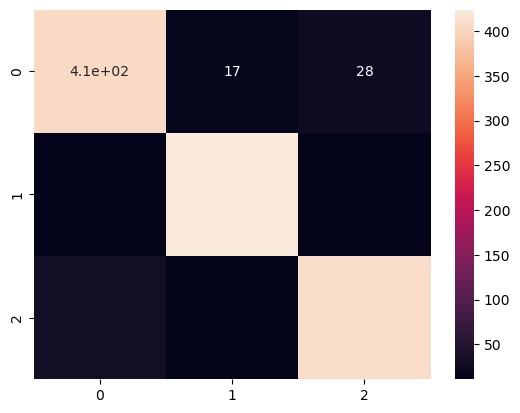

In [77]:
# Confusion Matrix

y_test_pred = model.predict(X_test)
y_test_pred_labels = np.array([np.argmax(y_) for y_ in y_test_pred])

cm = tf.math.confusion_matrix(labels = y_test, predictions = y_test_pred_labels)

sns.heatmap(cm, annot = True)
plt.show()

In [78]:
tp_0, tn_0 = cm[0][0], cm[1][1] + cm[1][2] + cm[2][1] + cm[2][2]
fp_0, fn_0 = cm[1][0] + cm[2][0], cm[0][1] + cm[0][2]

tp_1, tn_1 = cm[1][1], cm[0][0] + cm[0][2] + cm[2][0] + cm[2][2]
fp_1, fn_1 = cm[0][1] + cm[2][1], cm[1][0] + cm[1][2]

tp_2, tn_2 = cm[2][2], cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]
fp_2, fn_2 = cm[0][2] + cm[1][2], cm[2][0] + cm[2][1]

def describeCM(tp, tn, fp, fn, i):
    print(f"\n\nClass {label_map[i]} : \n")
    print(f"True Positives : {tp}\nTrue Negatives : {tn}\nFalse Positives : {fp}\nFalse Negatives : {fn}")
    precision, recall = tp / (tp + fp), tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f"\nPrecision : {precision}\nRecall (Sensitivity) : {recall}\nF1-Score : {f1}")

describeCM(tp_0, tn_0, fp_0, fn_0, 0)
describeCM(tp_1, tn_1, fp_1, fn_1, 1)
describeCM(tp_2, tn_2, fp_2, fn_2, 2)



Class AD : 

True Positives : 406
True Negatives : 856
False Positives : 44
False Negatives : 45

Precision : 0.9022222222222223
Recall (Sensitivity) : 0.9002217294900222
F1-Score : 0.9012208657047726


Class CI : 

True Positives : 424
True Negatives : 873
False Positives : 28
False Negatives : 26

Precision : 0.9380530973451328
Recall (Sensitivity) : 0.9422222222222222
F1-Score : 0.9401330376940132


Class CN : 

True Positives : 408
True Negatives : 860
False Positives : 41
False Negatives : 42

Precision : 0.9086859688195991
Recall (Sensitivity) : 0.9066666666666666
F1-Score : 0.9076751946607341


In [79]:
# Classification Report

clf_report = metrics.classification_report(y_test, y_test_pred_labels)
print(clf_report)

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       451
           1       0.94      0.94      0.94       450
           2       0.91      0.91      0.91       450

    accuracy                           0.92      1351
   macro avg       0.92      0.92      0.92      1351
weighted avg       0.92      0.92      0.92      1351



In [80]:
model.save("clf_model_final.h5")